<a href="https://colab.research.google.com/github/vimalankvk80/ProgrammingAssignment2/blob/master/Stress_Detection_Try1_llama3_FT_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stress Data/dreaddit-train2CS.csv", usecols=['text', 'label'], encoding='latin1')
df

,text,label
0,"ptsd He said he had not felt that way before, ...",1
1,"assistance Hey there r/assistance, Not sure if...",0
2,ptsd My mom then hit me with the newspaper and...,1
3,"relationships until i met my new boyfriend, he...",1
4,survivorsofabuse October is Domestic Violence ...,1
...,...,...
3548,ptsd i have horrible vivid nightmares every ni...,1
3549,relationships Also I can't think about both of...,1
3550,"relationships Furthermore, I told him before w...",1
3551,assistance Here's the link to my amazon wish l...,0


In [ ]:
# the classes are unbalanced.
df.label.value_counts()

,count
label,
1,1857
0,1696


In [ ]:
# passing values through str.len()
df["Text Length"]= df["text"].str.len()

In [ ]:
df["Text Length"].mean()

459.41204615817617

In [ ]:
 df["Text Length"].values.max()

1654

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(3553, 3)

In [ ]:
df.label.value_counts()

,count
label,
1,1857
0,1696


In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
import ftfy

In [ ]:
def clean_text(text):
    #regex = re.compile('[%s]' % re.escape('|'))
    #text = regex.sub(" ", text)
    words = ftfy.fix_text(text)
    #words = str(text).split()
    #words = [i.lower() + " " for i in words]
    #words = [i for i in words if not "http" in i]
    #words = " ".join(words)
    #words = words.translate(words.maketrans('', '', string.punctuation))
    return words

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [ ]:
df.cleaned_text.values[0]

'ptsd He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.'

In [ ]:
X=df.cleaned_text.str.lower().str.replace("\'", "'")

In [ ]:
X = X.str.replace("ain't", "is not").str.replace("don\'t", "do not").str.replace("it\'s", "it is").str.replace("i\'ve", "i have").str.replace("isn\'t", "is not").str.replace("\'s", "'s").str.replace("aren't", "are not").str.replace("im", "i am").str.replace("can't", "cannot").str.replace("That's", "That is").str.replace("b/c", "becuase").str.replace("'cause", "because").str.replace("could've", "could have").str.replace("couldn't", "could not").str.replace("didn't", "did not").str.replace("doesn't", "does not").str.replace("don't", "do not").str.replace("hadn't", "had not").str.replace("hasn't", "has not").str.replace("haven't", "have not").str.replace("he'd", "he would").str.replace("he'll", "he will").str.replace("he's", "he is").str.replace("how'd", "how did").str.replace("how'd'y", "how do you").str.replace("how'll", "how will").str.replace("how's", "how is").str.replace("I'd", "I would").str.replace("I'd've", "I would have").str.replace("I'll", "I will").str.replace("I'll've", "I will have").str.replace("I'm", "I am").str.replace("I've", "I have").str.replace("i'd", "i would").str.replace("i'd've", "i would have").str.replace("i'll", "i will")  .str.replace("i'll've", "i will have").str.replace("i'm", "i am").str.replace("i've", "i have").str.replace("isn't", "is not").str.replace("it'd", "it would").str.replace("it'd've", "it would have").str.replace("it'll", "it will").str.replace("it'll've", "it will have").str.replace("it's", "it is").str.replace("let's", "let us").str.replace("ma'am", "madam").str.replace("mayn't", "may not").str.replace("might've", "might have").str.replace("mightn't", "might not").str.replace("mightn't've", "might not have").str.replace("must've", "must have").str.replace("mustn't", "must not").str.replace("mustn't've", "must not have").str.replace("needn't", "need not").str.replace("needn't've", "need not have").str.replace("o'clock", "of the clock").str.replace("oughtn't", "ought not").str.replace("oughtn't've", "ought not have").str.replace("shan't", "shall not").str.replace("sha'n't", "shall not").str.replace("shan't've", "shall not have").str.replace("she'd", "she would").str.replace("she'd've", "she would have").str.replace("she'll", "she will").str.replace("she'll've", "she will have").str.replace("she's", "she is").str.replace("should've", "should have").str.replace("shouldn't", "should not").str.replace("shouldn't've", "should not have").str.replace("so've", "so have").str.replace("so's", "so as").str.replace("this's", "this is").str.replace("that'd", "that would").str.replace("that'd've", "that would have").str.replace("that's", "that is").str.replace("there'd", "there would").str.replace("there'd've", "there would have").str.replace("there's", "there is").str.replace("here's", "here is").str.replace("they'd", "they would").str.replace("they'd've", "they would have").str.replace("they'll", "they will").str.replace("they'll've", "they will have").str.replace("they're", "they are").str.replace("they've", "they have").str.replace("to've", "to have").str.replace("wasn't", "was not").str.replace("we'd", "we would").str.replace("we'd've", "we would have").str.replace("we'll", "we will").str.replace("we'll've", "we will have").str.replace("we're", "we are").str.replace("we've", "we have").str.replace("weren't", "were not").str.replace("what'll", "what will").str.replace("what'll've", "what will have").str.replace("what're", "what are").str.replace("what's", "what is").str.replace("what've", "what have").str.replace("when's", "when is").str.replace("when've", "when have").str.replace("where'd", "where did").str.replace("where's", "where is").str.replace("where've", "where have").str.replace("who'll", "who will").str.replace("who'll've", "who will have").str.replace("who's", "who is").str.replace("who've", "who have").str.replace("why's", "why is").str.replace("why've", "why have").str.replace("will've", "will have").str.replace("won't", "will not").str.replace("won't've", "will not have").str.replace("would've", "would have").str.replace("wouldn't", "would not").str.replace("wouldn't've", "would not have").str.replace("y'all", "you all").str.replace("y'all'd", "you all would").str.replace("y'all'd've", "you all would have").str.replace("y'all're", "you all are").str.replace("y'all've", "you all have").str.replace("you'd", "you would").str.replace("you'd've", "you would have").str.replace("you'll", "you will").str.replace("you'll've", "you will have").str.replace("you're", "you are").str.replace("you've", "you have").str.replace("cr", "crore").str.replace("yr", "year").str.replace("yrs", "years").str.replace("It\'s", "It is").str.replace(":","").str.replace("|", "").str.replace(",","").str.replace("@","").str.replace("#","").str.replace("$","").str.replace("%","").str.replace("^","").str.replace("&","").str.replace("*","").str.replace("(","").str.replace(")","").str.replace("[","").str.replace("]","").str.replace("{","").str.replace("}","").str.replace(";","").str.replace("/","").str.replace("<","").str.replace(">","").str.replace("\n","").str.replace("~","").str.replace("=","").str.replace("_","").str.replace("+","")

In [ ]:
X[0]

'ptsd he said he had not felt that way before suggeted i go rest and so ..trigger ahead if youi\'re a hypocondriac like me i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicroreous conspiracy a stupid "are you psychic" test or new age b.s. something i could even laugh at down the road. no i ended up reading that this sense of doom can be indicative of various health ailments one of which i am prone to.. so on top of my "doom" to my gloom..i am now f\'n worried about my heart. i do happen to have a physical in 48 hours.'

In [ ]:
Y=df.label
# Encode The Output Variable
# encode class values as integers

In [ ]:
from sklearn.model_selection import train_test_split
# Train and Test Split
#x_train1, x_test, y_train1, y_test = train_test_split(X , Y, test_size=0.1, shuffle=False, stratify=None, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.1, shuffle=False, stratify=None, random_state=42)
x_train1, x_test, y_train1, y_test = train_test_split(X , Y, test_size=0.1, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.1, stratify=y_train1, random_state=42)

In [ ]:
x_train[0:5]

,cleaned_text
2862,anxiety i have a vague fear that i get when i ...
1497,anxiety i just wanted to share because i am pr...
1834,ptsd they discharged me. i told a nurse at a h...
1723,relationships i meet a great guy we connect i ...
2644,assistance facebook url croreiss url please he...


In [ ]:
y_train[0:5]

,label
2862,1
1497,0
1834,1
1723,0
2644,0


In [ ]:
data = {"text": x_train,
        "label": y_train}

In [ ]:
data

{'text': 2862    anxiety i have a vague fear that i get when i ...
 1497    anxiety i just wanted to share because i am pr...
 1834    ptsd they discharged me. i told a nurse at a h...
 1723    relationships i meet a great guy we connect i ...
 2644    assistance facebook url croreiss url please he...
                               ...                        
 2231    survivorsofabuse she rebuffed most of the ti a...
 1318    ptsd why this is i amportant - the fda has app...
 833     relationships i also get really painful crorea...
 395     ptsd i have never done this before but we alwa...
 3209    almosthomeless good news is that my applicatio...
 Name: cleaned_text, Length: 2877, dtype: object,
 'label': 2862    1
 1497    0
 1834    1
 1723    0
 2644    0
        ..
 2231    0
 1318    0
 833     1
 395     1
 3209    1
 Name: label, Length: 2877, dtype: int64}

In [ ]:
df_train = pd.concat(data, axis = 1)
df_train

,text,label
2862,anxiety i have a vague fear that i get when i ...,1
1497,anxiety i just wanted to share because i am pr...,0
1834,ptsd they discharged me. i told a nurse at a h...,1
1723,relationships i meet a great guy we connect i ...,0
2644,assistance facebook url croreiss url please he...,0
...,...,...
2231,survivorsofabuse she rebuffed most of the ti a...,0
1318,ptsd why this is i amportant - the fda has app...,0
833,relationships i also get really painful crorea...,1
395,ptsd i have never done this before but we alwa...,1


In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train.shape

(2877, 2)

<Axes: xlabel='label'>

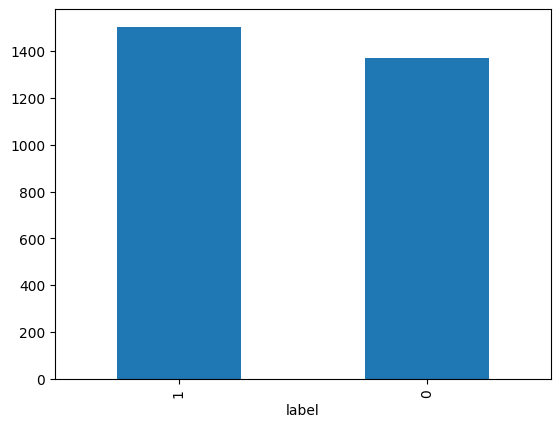

In [ ]:
df_train.label.value_counts().plot.bar()

In [ ]:
df_train.label.value_counts()

,count
label,
1,1504
0,1373


In [ ]:
data1 = {"text": x_val,
        "label": y_val}
data1

{'text': 2394    anxiety but i could feel construction workers ...
 162     ptsd one of the couples has a four-year-old da...
 1930    ptsd i feel like one of my worst symptoms is n...
 374     ptsd kinda interesting how even when i am not ...
 1143    ptsd this battle has been in the making for ye...
                               ...                        
 94      stress the si amplest breathing technique can ...
 3460    anxiety i need to be my own person however fla...
 2106    ptsd he brought me to hang out with the two of...
 2167    relationships if i ask her anything about her ...
 2602    homeless not actually losing my home at the mo...
 Name: cleaned_text, Length: 320, dtype: object,
 'label': 2394    1
 162     1
 1930    1
 374     1
 1143    0
        ..
 94      0
 3460    0
 2106    1
 2167    1
 2602    1
 Name: label, Length: 320, dtype: int64}

In [ ]:
df_val = pd.concat(data1, axis = 1)
df_val

,text,label
2394,anxiety but i could feel construction workers ...,1
162,ptsd one of the couples has a four-year-old da...,1
1930,ptsd i feel like one of my worst symptoms is n...,1
374,ptsd kinda interesting how even when i am not ...,1
1143,ptsd this battle has been in the making for ye...,0
...,...,...
94,stress the si amplest breathing technique can ...,0
3460,anxiety i need to be my own person however fla...,0
2106,ptsd he brought me to hang out with the two of...,1
2167,relationships if i ask her anything about her ...,1


In [ ]:
df_val.shape

(320, 2)

In [ ]:
data2 = {"text": x_test,
        "label": y_test}
data2

{'text': 1690    anxiety it is i amportant to put your needs fi...
 674     survivorsofabuse part of what makes good writi...
 564     foodpantry i am a freshman in college. i had t...
 3103    assistance anyway i just sort of got the news ...
 41      anxiety but i am really really afraid of publi...
                               ...                        
 1054    ptsd i really want others who can relate to th...
 3214    domesticviolence if he is the textbook abuser ...
 2458    anxiety but now i want that to change. my need...
 490     survivorsofabuse over the last 18 months we ha...
 2355    relationships to make up for it i made a cute ...
 Name: cleaned_text, Length: 356, dtype: object,
 'label': 1690    0
 674     0
 564     1
 3103    1
 41      0
        ..
 1054    0
 3214    0
 2458    1
 490     0
 2355    0
 Name: label, Length: 356, dtype: int64}

In [ ]:
df_test = pd.concat(data2, axis = 1)
df_test

,text,label
1690,anxiety it is i amportant to put your needs fi...,0
674,survivorsofabuse part of what makes good writi...,0
564,foodpantry i am a freshman in college. i had t...,1
3103,assistance anyway i just sort of got the news ...,1
41,anxiety but i am really really afraid of publi...,0
...,...,...
1054,ptsd i really want others who can relate to th...,0
3214,domesticviolence if he is the textbook abuser ...,0
2458,anxiety but now i want that to change. my need...,1
490,survivorsofabuse over the last 18 months we ha...,0


In [ ]:
df_train['label']=df_train['label'].astype('category')
df_train['target']=df_train['label'].cat.codes

df_train.head()

,text,label,target
2862,anxiety i have a vague fear that i get when i ...,1,1
1497,anxiety i just wanted to share because i am pr...,0,0
1834,ptsd they discharged me. i told a nurse at a h...,1,1
1723,relationships i meet a great guy we connect i ...,0,0
2644,assistance facebook url croreiss url please he...,0,0


In [ ]:
df_train['label'].cat.categories

Index([0, 1], dtype='int64')

In [ ]:
category_map = {code: category for code, category in enumerate(df_train['label'].cat.categories)}
category_map

{0: 0, 1: 1}

In [ ]:
df_val['label']=df_val['label'].astype('category')
df_val['target']=df_val['label'].cat.codes

df_val.head()

,text,label,target
2394,anxiety but i could feel construction workers ...,1,1
162,ptsd one of the couples has a four-year-old da...,1,1
1930,ptsd i feel like one of my worst symptoms is n...,1,1
374,ptsd kinda interesting how even when i am not ...,1,1
1143,ptsd this battle has been in the making for ye...,0,0


In [ ]:
df_test['label']=df_test['label'].astype('category')
df_test['target']=df_test['label'].cat.codes

df_test.head()

,text,label,target
1690,anxiety it is i amportant to put your needs fi...,0,0
674,survivorsofabuse part of what makes good writi...,0,0
564,foodpantry i am a freshman in college. i had t...,1,1
3103,assistance anyway i just sort of got the news ...,1,1
41,anxiety but i am really really afraid of publi...,0,0


In [ ]:
print(df_train.shape, df_test.shape, df_val.shape)

(2877, 3) (356, 3) (320, 3)


In [ ]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

In [ ]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [ ]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'target', '__index_level_0__'],
        num_rows: 2877
    })
    val: Dataset({
        features: ['text', 'target', '__index_level_0__'],
        num_rows: 320
    })
    test: Dataset({
        features: ['text', 'target', '__index_level_0__'],
        num_rows: 356
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['text', 'target', '__index_level_0__'],
    num_rows: 2877
})

In [ ]:
#df_train.target.value_counts(normalize=True)

In [ ]:
#class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
#class_weights=torch.tensor(class_weights)
#class_weights=class_weights/class_weights.sum()
#class_weights

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


In [ ]:
lora_config = LoraConfig(
    r = 64, # the dimension of the low-rank matrices
    lora_alpha = 16, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=2
)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [ ]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
sentences = df_val.text.tolist()
sentences[0:2]

['anxiety but i could feel construction workers staring at me. i know i might be paranoid but i do not want to take chances anymore i am scared. i already paid for a year at the gym about 6 months ago. do you think i should talk to someone about getting at least a partial refund for the 6 months? i do not want to bring my situation up to them and have them say sorry but not our problem.',
 'ptsd one of the couples has a four-year-old daughter. we live in a two bedroom apartment. i constantly have to do shit for these people. one of the wives scolds me  constantly and tells me i need to show more respect for my parents. they leave needles out everywhere and when i inevitably step on one i will probably end up with an std.']

In [ ]:
sentences1 = df_test.text.tolist()
sentences1[0:2]

['anxiety it is i amportant to put your needs first someti ames. this might sound really obvious but i never realized just how harmful it can be to try and please everyone all the ti ame. whether you speak your mind or do not there is always going to be someone who dislikes you. i think it is i amportant to realize that there is value in your personal expression so it is worth the risk of offending a few people. i just have not been able to see the value in my own words for so long.',
 'survivorsofabuse part of what makes good writing is having small specific details and the little stories that make up the novel as a whole. this is why i was hoping that if you are interested you could send me stories of your experiences in an abusive relationship - whatever detail you choose to send it does not have to be anything "epic" and "grand" it could be the smallest segment that you hold significance to. if you have any questions about what i am looking for let me know - though i am really look

In [ ]:
# Convert summaries to a list
sentences = df_val.text.tolist()

# Define the batch size
batch_size = 4  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])


In [ ]:
# Convert summaries to a list
sentences1 = df_test.text.tolist()

# Define the batch size
batch_size1 = 4  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs1 = []

# Process the sentences in batches
for i in range(0, len(sentences1), batch_size1):
    # Get the batch of sentences
    batch_sentences = sentences1[i:i + batch_size1]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs1.append(outputs['logits'])


In [ ]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[ 6.1761e-01,  5.2700e-01],
        [ 3.8718e-01,  3.3762e+00],
        [-5.9347e-01,  2.2054e+00],
        [ 4.2267e+00,  2.5322e+00],
        [ 7.9553e-01,  2.2376e-01],
        [ 4.3209e+00,  4.6521e+00],
        [ 9.9653e-01,  7.4752e-01],
        [-1.2750e+00,  3.2435e+00],
        [-7.8461e-01,  2.6091e+00],
        [ 7.9657e-01,  1.5038e+00],
        [-2.3226e-01,  3.7077e+00],
        [ 3.8549e-01,  4.1881e+00],
        [ 2.8663e+00,  3.1990e+00],
        [-1.4174e-01,  1.9687e+00],
        [ 2.9158e+00,  6.5647e+00],
        [-1.2245e+00,  4.0373e+00],
        [-2.7118e+00,  4.0259e+00],
        [ 4.6183e-02,  1.8374e+00],
        [ 4.4850e-01,  4.0514e+00],
        [ 1.6778e+00,  6.5970e+00],
        [ 2.3649e+00,  3.0859e+00],
        [ 3.2595e-01,  1.7027e+00],
        [ 2.0826e-01, -2.5254e-01],
        [ 8.6317e-01,  5.8947e+00],
        [-2.3309e+00,  4.3816e+00],
        [ 3.7429e+00,  4.6470e+00],
        [ 2.2603e+00,  9.9367e-01],
        [-9.0287e-01,  5.374

In [ ]:
final_outputs1 = torch.cat(all_outputs1, dim=0)
final_outputs1

tensor([[ 3.4059e+00,  5.2725e+00],
        [ 3.4189e+00,  2.7210e-02],
        [-1.8364e+00,  3.4660e+00],
        [-5.7047e-01,  1.3882e+00],
        [ 2.4567e-01,  5.1570e+00],
        [ 2.7822e+00,  4.7172e+00],
        [-4.2657e+00,  1.0044e+00],
        [-7.1658e-01,  3.6543e+00],
        [ 6.8152e-01,  2.4768e+00],
        [ 1.4357e+00,  1.9971e+00],
        [-1.0087e+00,  1.6544e+00],
        [ 4.2689e+00,  6.4555e+00],
        [ 1.3304e+00,  3.5654e+00],
        [ 3.9563e-01,  5.0552e+00],
        [ 2.6448e+00,  4.2338e+00],
        [ 2.8085e+00,  2.1989e+00],
        [ 7.3453e-01,  3.2325e+00],
        [ 1.6983e+00,  5.4663e+00],
        [ 3.1705e+00,  5.2405e+00],
        [ 1.0986e+00,  2.2051e+00],
        [ 5.0990e+00,  1.6592e+00],
        [ 1.4738e+00,  4.9216e+00],
        [ 1.0871e+00,  1.4426e+00],
        [ 3.2132e+00,  4.3390e+00],
        [ 9.9697e-01,  5.7135e+00],
        [-3.9997e-01,  4.4820e+00],
        [ 1.1227e+00,  2.7473e+00],
        [ 1.0872e+00,  3.271

In [ ]:
final_outputs.argmax(axis=1)

tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
final_outputs1.argmax(axis=1)

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,

In [ ]:
df_val['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_val['predictions']

,predictions
2394,0
162,1
1930,1
374,0
1143,0
...,...
94,0
3460,1
2106,1
2167,0


In [ ]:
df_test['predictions']=final_outputs1.argmax(axis=1).cpu().numpy()
df_test['predictions']

,predictions
1690,1
674,0
564,1
3103,1
41,1
...,...
1054,1
3214,1
2458,0
490,1


In [ ]:
df_val['predictions'].value_counts()

,count
predictions,
1,256
0,64


In [ ]:
df_test['predictions'].value_counts()

,count
predictions,
1,294
0,62


In [ ]:
df_val['predictions']=df_val['predictions'].apply(lambda l:category_map[l])
df_val['predictions']

,predictions
2394,0
162,1
1930,1
374,0
1143,0
...,...
94,0
3460,1
2106,1
2167,0


In [ ]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

,predictions
1690,1
674,0
564,1
3103,1
41,1
...,...
1054,1
3214,1
2458,0
490,1


In [ ]:
def get_performance_metrics(df_val):
  y_test = df_val.label
  y_pred = df_val.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Valid Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Valid Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
def get_performance_metrics1(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Test Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Test Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
get_performance_metrics(df_val)

Confusion Matrix:
[[ 26 127]
 [ 38 129]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.17      0.24       153
           1       0.50      0.77      0.61       167

    accuracy                           0.48       320
   macro avg       0.46      0.47      0.42       320
weighted avg       0.46      0.48      0.43       320

Balanced Valid Accuracy Score: 0.47119486517161757
Valid Accuracy Score: 0.484375


In [ ]:
get_performance_metrics1(df_test)

Confusion Matrix:
[[ 29 141]
 [ 33 153]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.17      0.25       170
           1       0.52      0.82      0.64       186

    accuracy                           0.51       356
   macro avg       0.49      0.50      0.44       356
weighted avg       0.50      0.51      0.45       356

Balanced Test Accuracy Score: 0.496584440227704
Test Accuracy Score: 0.5112359550561798


In [ ]:
MAX_LEN = 512
col_to_delete = ['text']

def llama_preprocessing_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/2877 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
training_args = TrainingArguments(
    output_dir = '5GSPEC_classification',
    learning_rate = 3e-4,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    #class_weights=class_weights,
)

In [ ]:
train_result = trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.963500,0.567426,0.860596,0.850000


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
def make_predictions(model,df_val):


  # Convert summaries to a list
  sentences = df_val.text.tolist()

  # Define the batch size
  batch_size = 4  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_val['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_val['predictions']=df_val['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_val)

In [ ]:
def make_predictions1(model,df_test):


  # Convert summaries to a list
  sentences = df_test.text.tolist()

  # Define the batch size
  batch_size = 4  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions1(model,df_test)

In [ ]:
get_performance_metrics(df_val)

In [ ]:
get_performance_metrics1(df_test)

In [ ]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

In [ ]:
#trainer.save_model("/content/drive/MyDrive/llama-3 trained_model/saved_model")

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!nvidia-smi